Демьянчук Г.В. ИУ5-22М Л/Р №4

# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей<cite data-cite="ue:lab4"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab4"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите модель ближайших соседей для&nbsp;произвольно заданного гиперпараметра $K$. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик.
5. Постройте модель и оцените качество модели с&nbsp;использованием кросс-валидации. Проведите эксперименты с&nbsp;тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра $K$ с&nbsp;использованием `GridSearchCV` и кросс-валидации.
7. Повторите пункт&nbsp;4 для&nbsp;найденного оптимального значения гиперпараметра $K$. Сравните качество полученной модели с&nbsp;качеством модели, полученной в&nbsp;пункте&nbsp;4.
8. Постройте кривые обучения и валидации.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [0]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [0]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются оценка качества белых вин по шкале с учетом химических мер каждого вина:

In [0]:
data = pd.read_csv("/content/whitew.csv")

Проверим полученные типы:

In [46]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [47]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [48]:
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [49]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Проверим размер набора данных:

In [50]:
df.shape

(1599, 12)

Проверим основные статистические характеристики набора данных:

In [51]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Проверим наличие пропусков в&nbsp;данных:

In [52]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [0]:
X = df.drop("density", axis=1)
y = df["density"]

In [54]:
print(X.head(), "\n")
print(y.head())

   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 11 columns] 

0    0.9978
1    0.9968
2    0.9970
3    0.9980
4    0.9978
Name: density, dtype: float64


In [55]:
print(X.shape)
print(y.shape)

(1599, 11)
(1599,)


Предобработаем данные, чтобы методы работали лучше:

In [56]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,3.435512e-16,1.699704e-16,4.335355e-16,-1.905223e-16,4.838739e-16,1.432042e-16,1.289532e-16,3.002879e-15,7.639596e-16,9.437243e-16,-8.051373e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.137045e+00,-2.278280e+00,-1.391472e+00,-1.162696e+00,-1.603945e+00,-1.422500e+00,-1.230584e+00,-3.700401e+00,-1.936507e+00,-1.898919e+00,-3.265165e+00
25%,-7.007187e-01,-7.699311e-01,-9.293181e-01,-4.532184e-01,-3.712290e-01,-8.487156e-01,-7.440403e-01,-6.551405e-01,-6.382196e-01,-8.663789e-01,-7.878226e-01
50%,-2.410944e-01,-4.368911e-02,-5.636026e-02,-2.403750e-01,-1.799455e-01,-1.793002e-01,-2.574968e-01,-7.212705e-03,-2.251281e-01,-2.093081e-01,4.508484e-01
75%,5.057952e-01,6.266881e-01,7.652471e-01,4.341614e-02,5.384542e-02,4.901152e-01,4.723184e-01,5.759223e-01,4.240158e-01,6.354971e-01,4.508484e-01
max,4.355149e+00,5.877976e+00,3.743574e+00,9.195681e+00,1.112703e+01,5.367284e+00,7.375154e+00,4.528282e+00,7.918677e+00,4.202453e+00,2.928190e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1199, 11)
(400, 11)
(1199,)
(400,)


## Модель ближайших соседей для произвольно заданного гиперпараметра $K$

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

Попробуем метод ближайших соседей с&nbsp;гиперпараметром $K=5$:

In [60]:
reg_5 = KNeighborsRegressor(n_neighbors=5)
reg_5.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

Проверим метрики построенной модели:

In [61]:
test_model(reg_5)

mean_absolute_error: 0.0006631799999999915
median_absolute_error: 0.0004889999999999617
r2_score: 0.7565853831960054


Видно, что средние ошибки не&nbsp;очень показательны для&nbsp;одной модели, они больше подходят для&nbsp;сравнения разных моделей. В&nbsp;тоже время коэффициент детерминации неплох сам по&nbsp;себе, в&nbsp;данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Проверим различные стратегии кросс-валидации. Для&nbsp;начала посмотрим классический K-fold:

In [62]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.54201038 0.62530238 0.60103483 0.42462355 0.16800613 0.67138819
 0.69157226 0.54801332 0.58253055 0.60540914]
0.5459890743612823 ± 0.14447376628869613


In [63]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2),
                         scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.73450664 0.75859279 0.71236101 0.75826791 0.73064159 0.73583826
 0.73708952 0.72441664 0.76320957 0.73085156]
0.7385775486996173 ± 0.01559440793882926


In [64]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.76101624 0.74486624 0.78022773 0.74529884 0.72949467 0.73281696
 0.75714985 0.75469655 0.75203314 0.80103417]
0.7558634383711698 ± 0.02034024152887018


## Подбор гиперпараметра $K$

Введем список настраиваемых параметров:

In [65]:
n_range = np.array(range(1, 50, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

Запустим подбор параметра:

In [66]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 3}

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

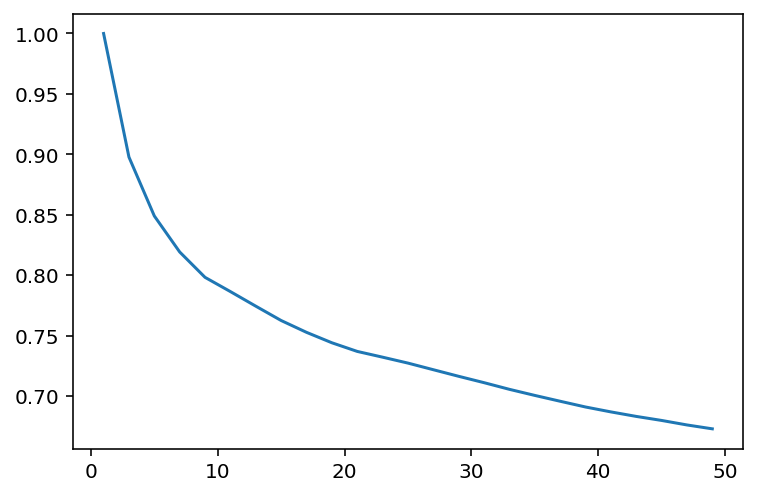

In [67]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для&nbsp;$K=1$ на&nbsp;тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

На&nbsp;тестовом наборе данных картина сильно интереснее:

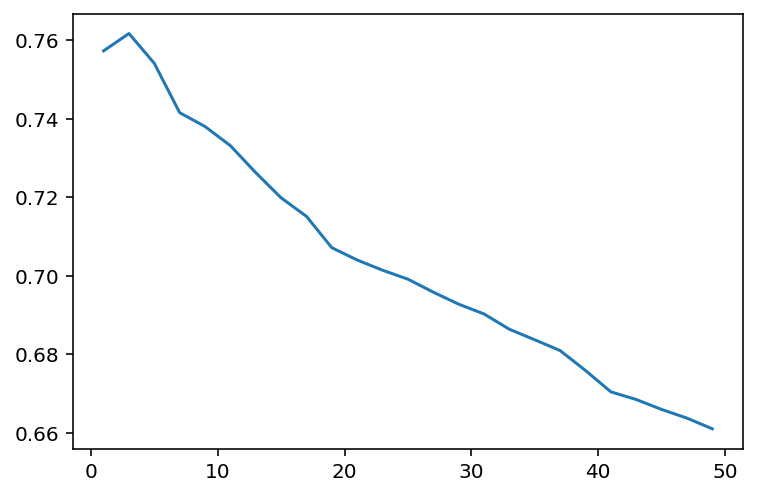

In [68]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Выходит, что сначала соседей слишком мало (высоко влияние выбросов), а затем количество соседей постепенно становится слишком велико, и среднее значение по&nbsp;этим соседям всё больше и больше оттягивает значение от&nbsp;истинного.

Проверим получившуюся модель:

In [69]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.0006740416666666596
median_absolute_error: 0.0005033333333333001
r2_score: 0.7550997432386466


В&nbsp;целом получили примерно тот же результат. Очевидно, что проблема в&nbsp;том, что данный метод и так показал достаточно хороший результат для&nbsp;данной выборки.

Построим кривую обучения<cite data-cite="doc:sklearn"></cite>:

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

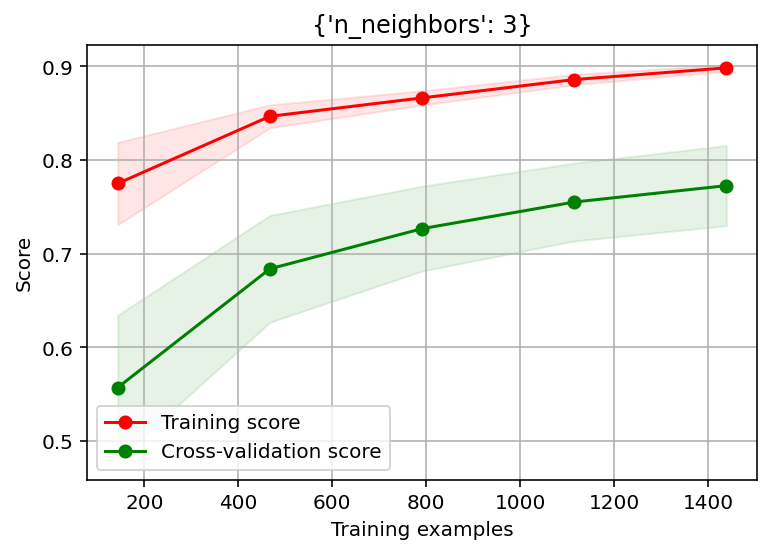

In [71]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [0]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

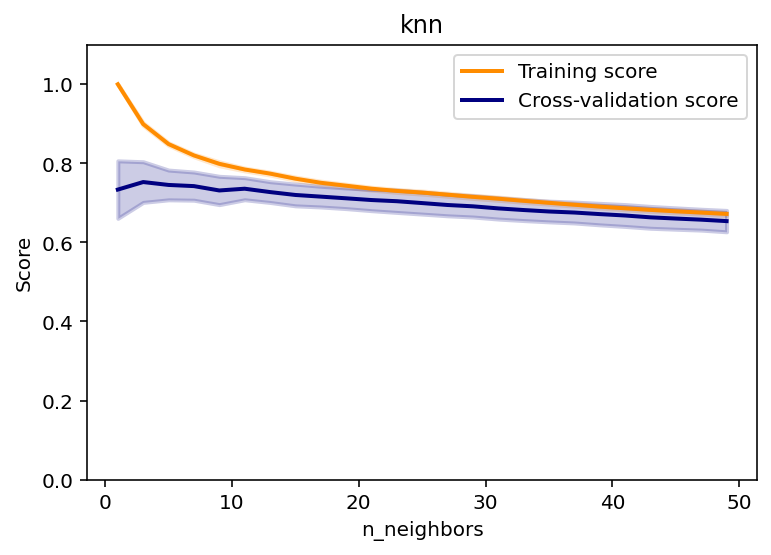

In [73]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10), scoring="r2");